In [1]:
%pylab inline

import pyart
import wradlib as wrl
import pandas as pd
import tempfile
import os
import pandas as pd

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature

from copy import deepcopy
import boto3
from botocore.handlers import disable_signing

import datetime as dt
import pytz

import scipy.signal as ss
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib

## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/wradlib/io/radolan.py:835: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'RR': {'add_offset': np.float(0),
/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/wradlib/io/radolan.py:842: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  'RA': {'add_offset': np.float(0),


In [2]:
datadir = './QVPsector_10deg/'
fnamelist = os.listdir(datadir)
fnamelist = [f for f in fnamelist if f.startswith('qvp_sector_10deg')]
fnamelist.sort()

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
len(fnamelist)

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


1151

In [4]:
#d = np.load('qvp_10deg_20150206.hdf5.npy', allow_pickle=True)
fname = os.path.join(datadir,'qvp_sector_10deg_20041019.hdf5.npy')
d = np.load(fname, allow_pickle=True)

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
qvp_sea_refl = d.item()['qvp_sea_reflectivity']
qvp_sea_time = d.item()['qvp_sea_time']
qvp_sea_height = d.item()['qvp_sea_height']
qvp_sea_range = d.item()['qvp_sea_range']

qvp_land_refl = d.item()['qvp_land_reflectivity']
qvp_land_time = d.item()['qvp_land_time']
qvp_land_height = d.item()['qvp_land_height']
qvp_land_range = d.item()['qvp_land_range']

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
len(qvp_land_refl)

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


248

# Find peaks

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


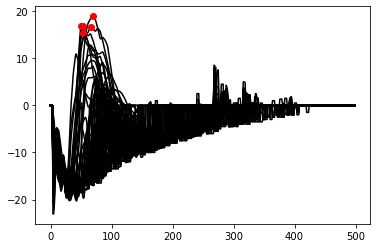

In [7]:
peaks = []
peaks_y = []

for i in range(0,80,1):#len(qvp_land_refl)):
    test_signal = qvp_land_refl[i][:500]
    pk = ss.find_peaks(test_signal,prominence=3, width=3, height=15) #height = minimum reflectivity
    peaks.append(pk[0])
    
    test_signaly = test_signal[pk[0]]
    peaks_y.append(test_signaly)
    
    plt.plot(test_signal,'k-')
    plt.plot(pk[0],test_signaly,'ro')

In [8]:
peaks = []
peaks_y = []
ML_heights = []

for i in range(len(qvp_land_refl)):
    test_signal = qvp_land_refl[i][:500]
    pk,meta = ss.find_peaks(test_signal,prominence=3, width=3, height=15)
    peaks.append(pk)

    test_signaly = test_signal[pk]
    peaks_y.append(test_signaly)


    try:
        max_idx = np.where(meta['peak_heights'] == max(meta['peak_heights']))[0][0]
        MLheight = qvp_land_height[i][pk[max_idx]]
        ML_heights.append(MLheight)
        
    except ValueError:
        ML_heights.append(np.nan)

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
def find_peaks(refl,height,min_refl=20):
    
    peaks = []
    peaks_y = []
    ML_heights = []

    for i in range(len(refl)):
        test_signal = refl[i][:500]
        # pk,meta = ss.find_peaks(test_signal,prominence=3, width=3, height=min_refl)
        pk,meta = ss.find_peaks(test_signal,width=[3,15],rel_height=0.2, height=min_refl) # height is minimum reflectivity considered as ML
        peaks.append(pk)

        test_signaly = test_signal[pk]
        peaks_y.append(test_signaly)
        
        try:
            max_idx = np.where(meta['peak_heights'] == max(meta['peak_heights']))[0][0]
            MLheight = qvp_land_height[i][pk[max_idx]]
            ML_heights.append(MLheight)
        except ValueError:
            ML_heights.append(np.nan)

    return ML_heights

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
%%time
mlh_sea = []
mlh_land = []
mlh_time = []
mlh_sea_count = []
mlh_land_count = []

for fname in fnamelist:
    d = np.load(os.path.join(datadir,fname), allow_pickle=True)
    
    qvp_sea_refl = d.item()['qvp_sea_reflectivity']
    qvp_sea_time = d.item()['qvp_sea_time']
    qvp_sea_height = d.item()['qvp_sea_height']
    qvp_sea_range = d.item()['qvp_sea_range']

    qvp_land_refl = d.item()['qvp_land_reflectivity']
    qvp_land_time = d.item()['qvp_land_time']
    qvp_land_height = d.item()['qvp_land_height']
    qvp_land_range = d.item()['qvp_land_range']
    
    mlh_sea_ = find_peaks(qvp_sea_refl,qvp_sea_height)
    mlh_land_ = find_peaks(qvp_land_refl,qvp_land_height)
    
    mlh_sea_ave = np.nanmean(mlh_sea_)
    mlh_land_ave = np.nanmean(mlh_land_)
    
    # count number of peaks detected over number of QVP processed
    mlh_sea_count_ = np.count_nonzero(~np.isnan(mlh_sea_)) / float(len(mlh_sea_))
    mlh_land_count_ = np.count_nonzero(~np.isnan(mlh_land_)) / float(len(mlh_land_))
    
    mlh_sea.append(np.array(mlh_sea_ave))
    mlh_land.append(np.array(mlh_land_ave))
    mlh_time.append(qvp_sea_time[0].date())
    mlh_sea_count.append(mlh_sea_count_)
    mlh_land_count.append(mlh_land_count_)

mlh_sea = np.array(mlh_sea)
mlh_land = np.array(mlh_land)
mlh_time = np.array(mlh_time)
mlh_sea_count = np.array(mlh_sea_count)
mlh_land_count = np.array(mlh_land_count)

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice
/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


CPU times: user 47.7 s, sys: 6.3 s, total: 54 s
Wall time: 1min 57s


/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


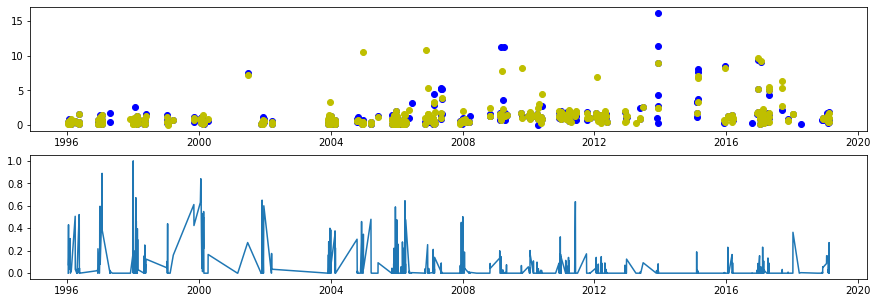

In [11]:
fig = plt.figure(figsize=(15,5))
ax1 = fig.add_subplot(211)
ax1.plot(mlh_time,mlh_sea/1000.,'bo')
ax1.plot(mlh_time,mlh_land/1000.,'yo')

ax2 = fig.add_subplot(212)
ax2.plot(mlh_time, mlh_sea_count)

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


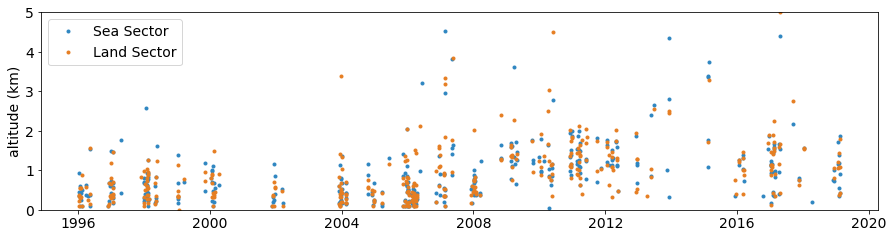

In [12]:
font = {'family' : 'sans-serif',
        'weight' : 'regular',
        'size'   : 14}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(15,8))
ax1 = fig.add_subplot(211)
ax1.plot(mlh_time,mlh_sea/1000.,marker='o', linewidth=0, color='#2E86C1', ms=3, label='Sea Sector')
ax1.plot(mlh_time,mlh_land/1000.,color='#E67E22',marker='o', linewidth=0, ms=3, label='Land Sector')
ax1.set_ylabel('altitude (km)')

#ax1.axhline(y=0)
ax1.set_ylim(0,5)

ax1.legend()

* each data point is a day
* for days that have no detected precip, ML value is NaN


### Create pandas dataframe

In [13]:
dat = {'DateTime':mlh_time,
       'MeltingLayerHeight_sea': mlh_sea,
       'MeltingLayerHeight_land': mlh_land}

df = pd.DataFrame(dat)
df['DateTime'] = pd.to_datetime(df['DateTime'] )
df = df.set_index('DateTime')
df['Year'] = df.index.year

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
df = df.loc[(df['MeltingLayerHeight_sea'] < 6000)]

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


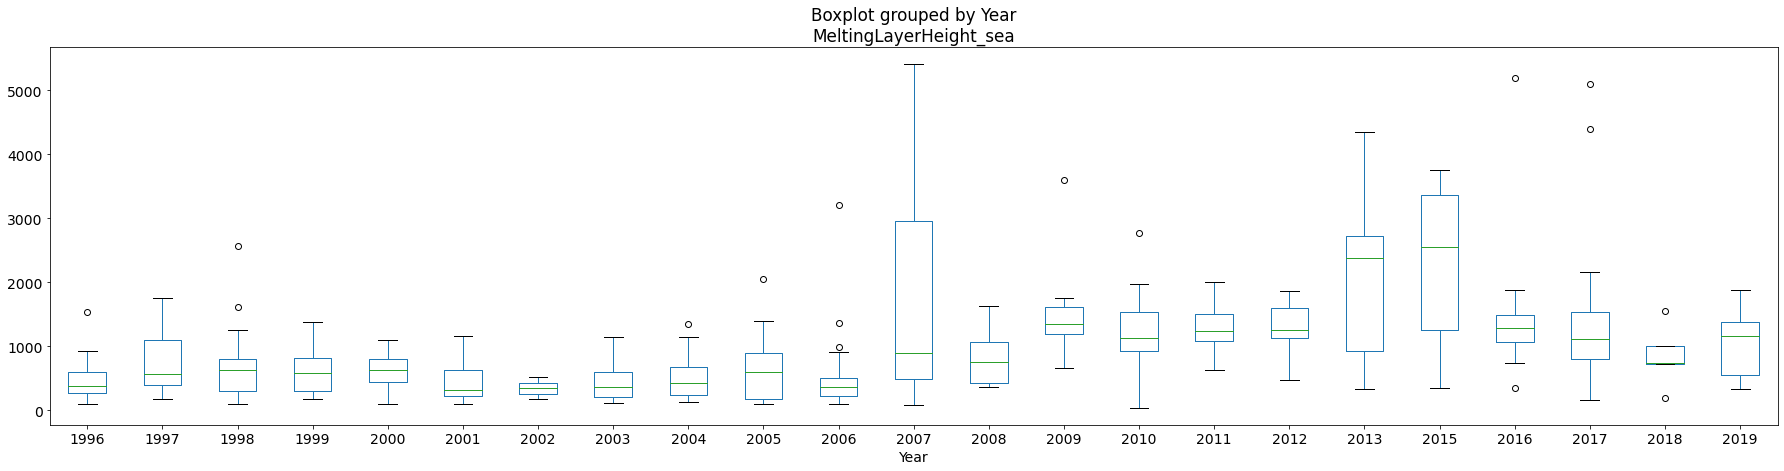

In [15]:
df.boxplot(by ='Year', column =['MeltingLayerHeight_sea'], grid = False, figsize=(30,7)) 
plt.savefig('boxplot_MLsea.png')

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


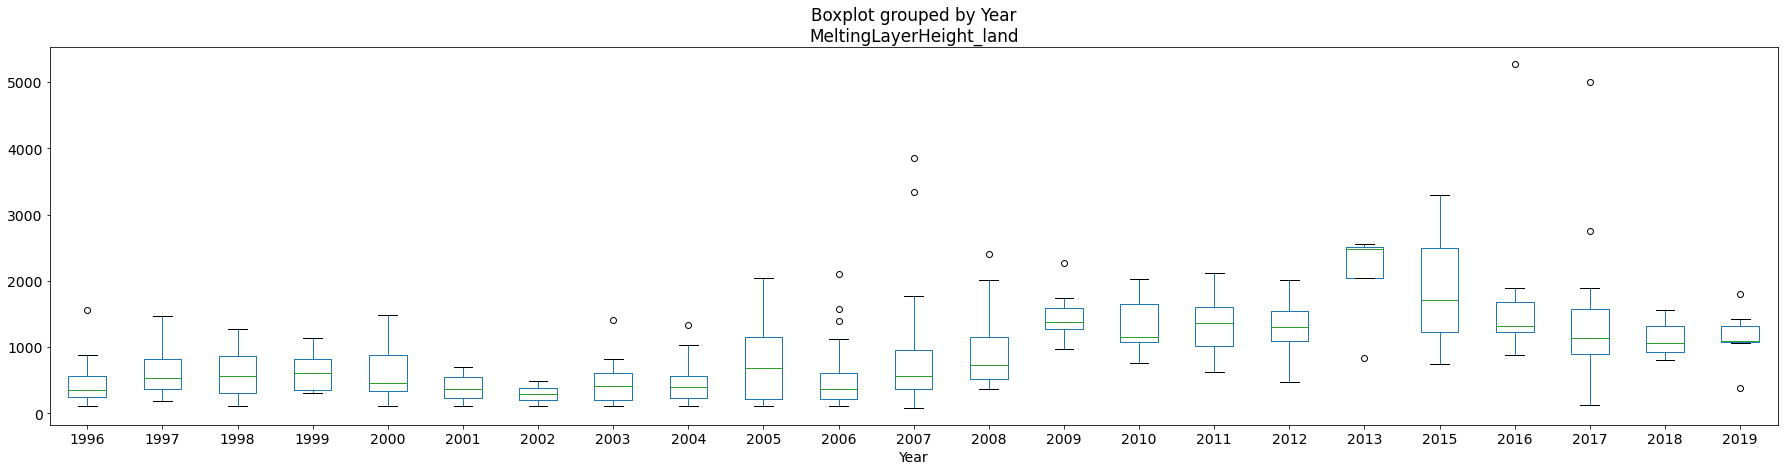

In [16]:
df.boxplot(by ='Year', column =['MeltingLayerHeight_land'], meanline=True, grid = False, figsize=(30,7)) 
#plt.savefig('boxplot_MLland.png')

In [17]:
dat_sea = {'DateTime':mlh_time,
       'MeltingLayerHeight': mlh_sea/1000.,
          'Location' : 'sea'}
dat_land = {'DateTime':mlh_time,
       'MeltingLayerHeight': mlh_land/1000.,
            'Location' : 'land'}
           
dfsea = pd.DataFrame(dat_sea)
dfland = pd.DataFrame(dat_land)

dfsea.index = dfsea['DateTime']
dfland.index = dfland['DateTime']

# remove some duplicated indices because they cause error
dfsea = dfsea[~dfsea.index.duplicated()]
dfland = dfland[~dfland.index.duplicated()]
# fill up the index
dfsea = dfsea.asfreq('D',fill_value=np.nan)
dfland = dfland.asfreq('D',fill_value=np.nan)

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
df2 = pd.concat([dfsea,dfland],axis=0)
df2['DateTime'] = pd.to_datetime(df2['DateTime'] )
#df2 = df2.set_index('DateTime')
df2['Year'] = df2['DateTime'].dt.year

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
df2.head()

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,DateTime,MeltingLayerHeight,Location,Year
DateTime,,,,
1996-01-15,1996-01-15,NaN,sea,1996.0
1996-01-16,1996-01-16,0.439833,sea,1996.0
1996-01-17,NaT,NaN,NaN,NaN
1996-01-18,1996-01-18,0.357545,sea,1996.0
1996-01-19,1996-01-19,0.928733,sea,1996.0


/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


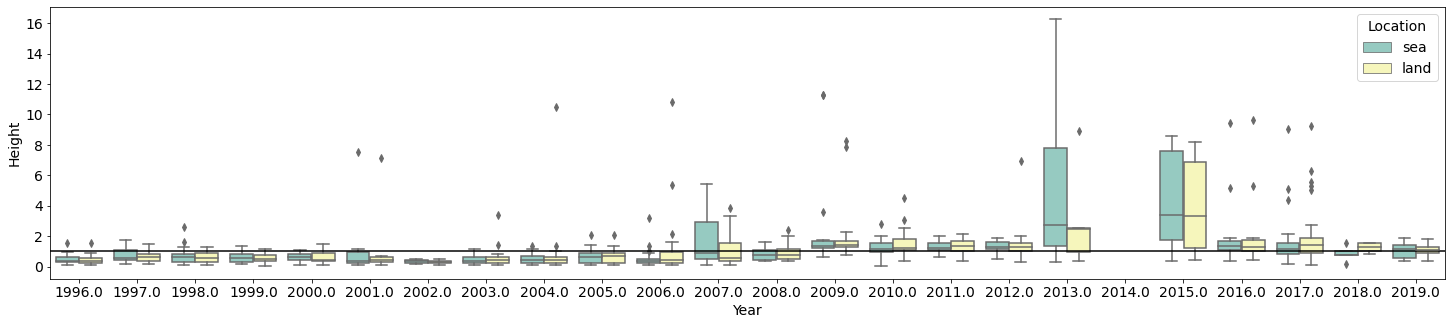

In [20]:
fig, ax = pyplot.subplots(figsize =(25, 5)) 
ax = sns.boxplot(x="Year", y="MeltingLayerHeight", hue="Location",
                 data=df2, palette="Set3")
ax.set_ylabel('Height')
ax.axhline(y=1, color='k')

In [21]:
roll_mean = dfsea.rolling(window=1000,min_periods=1, win_type='triang').mean()

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0, 0.5, 'height (km)')

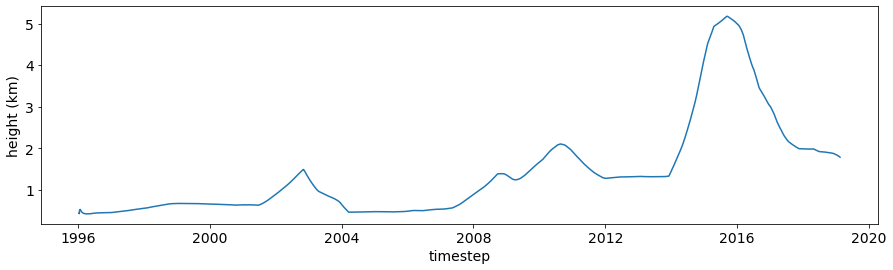

In [22]:
fig, ax = pyplot.subplots(figsize =(15, 4)) 
plt.plot(roll_mean.index, roll_mean.MeltingLayerHeight)
plt.xlabel('timestep')
plt.ylabel('height (km)')

In [23]:
roll_std = dfsea.rolling(window=45,min_periods=1, win_type='triang').std()

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


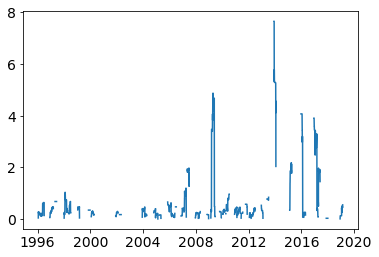

In [24]:
plt.plot(roll_std.index, roll_std.MeltingLayerHeight)

In [25]:
data_count = {}
#y = np.arange(1996,2020,1)
for y in range(1996,2020,1):
    data_count[str(y)] = 0
    
    for f in fnamelist:
        if f[17:21] == str(y):
            data_count[str(y)] +=1 

print("Data points per year:")
print(data_count)
#plt.plot(y,data_count)

Data points per year:
{'1996': 33, '1997': 17, '1998': 51, '1999': 14, '2000': 16, '2001': 16, '2002': 5, '2003': 23, '2004': 47, '2005': 67, '2006': 124, '2007': 60, '2008': 44, '2009': 88, '2010': 101, '2011': 80, '2012': 99, '2013': 46, '2014': 2, '2015': 33, '2016': 68, '2017': 87, '2018': 15, '2019': 15}


/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Re-count data per year based on dataframe, not filenames.

In [26]:
df2.to_csv('KMUX_MeltingLayer_heights.csv')

/home/icrisologo/.conda/envs/pyart/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
